In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [43]:
data = pd.read_csv("../data/processed/claims_feature.csv")
data

,age,sex,bmi,children,smoker,region,charges,bmi_category,age_category
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight,Young Adults
1,18,male,33.770,1,no,southeast,1725.55230,Obese,Young Adults
2,28,male,33.000,3,no,southeast,4449.46200,Obese,Young Adults
3,33,male,22.705,0,no,northwest,21984.47061,Normal,Established Adults
4,32,male,28.880,0,no,northwest,3866.85520,Overweight,Established Adults
...,...,...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830,Obese,Mature Adults
1333,18,female,31.920,0,no,northeast,2205.98080,Obese,Young Adults
1334,18,female,36.850,0,no,southeast,1629.83350,Obese,Young Adults
1335,21,female,25.800,0,no,southwest,2007.94500,Overweight,Young Adults


In [44]:
data = data.drop(['bmi_category', 'age_category'], axis=1)
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


In [45]:
numerical_features = data.select_dtypes(include=np.number).columns
categorical_features = data.select_dtypes(include="object").columns

In [46]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [47]:
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])
data

,age,sex,bmi,children,smoker,region,charges
0,0.021739,0,0.321227,0.0,1,3,0.251611
1,0.000000,1,0.479150,0.2,0,2,0.009636
2,0.217391,1,0.458434,0.6,0,2,0.053115
3,0.326087,1,0.181464,0.0,0,1,0.333010
4,0.304348,1,0.347592,0.0,0,1,0.043816
...,...,...,...,...,...,...,...
1332,0.695652,1,0.403820,0.6,0,1,0.151299
1333,0.000000,0,0.429379,0.0,0,0,0.017305
1334,0.000000,0,0.562012,0.0,0,2,0.008108
1335,0.065217,0,0.264730,0.0,0,3,0.014144


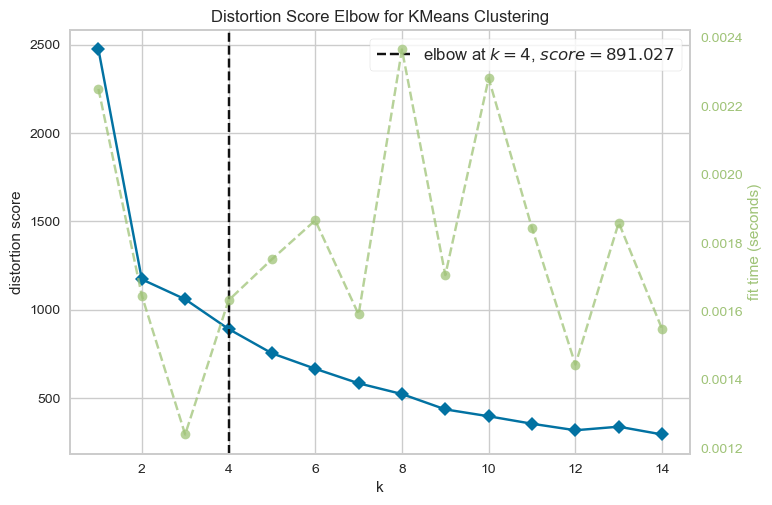

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1, 15))
visualizer.fit(data)
visualizer.show()

In [49]:
kmeans = KMeans(n_clusters=2).fit(data)
labels = kmeans.labels_
score = silhouette_score(data, labels)
print("Silhouette Score: ", score)
data['Cluster'] = kmeans.fit_predict(data)
data

Silhouette Score:  0.43136407747521327


,age,sex,bmi,children,smoker,region,charges,Cluster
0,0.021739,0,0.321227,0.0,1,3,0.251611,1
1,0.000000,1,0.479150,0.2,0,2,0.009636,1
2,0.217391,1,0.458434,0.6,0,2,0.053115,1
3,0.326087,1,0.181464,0.0,0,1,0.333010,0
4,0.304348,1,0.347592,0.0,0,1,0.043816,0
...,...,...,...,...,...,...,...,...
1332,0.695652,1,0.403820,0.6,0,1,0.151299,0
1333,0.000000,0,0.429379,0.0,0,0,0.017305,0
1334,0.000000,0,0.562012,0.0,0,2,0.008108,1
1335,0.065217,0,0.264730,0.0,0,3,0.014144,1


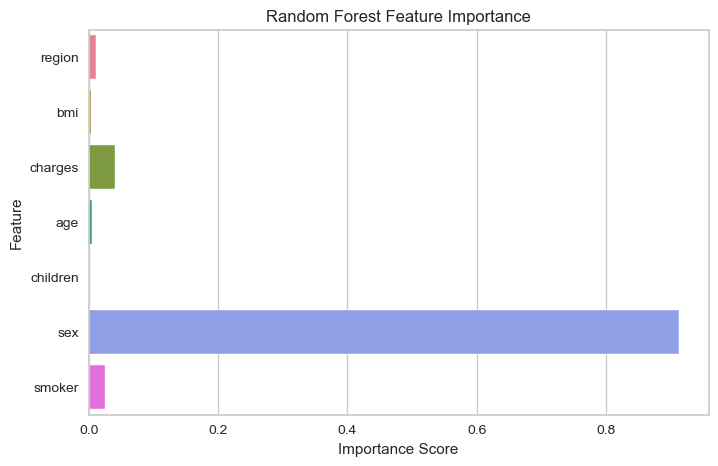

In [50]:
import seaborn as sns
X = data.drop(columns=['Cluster'])
y = data['Cluster']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
if hasattr(X, "columns"):
    feature_names = list(X.columns)
else:
    feature_names = [f"feature_{i}" for i in range(X.shape[1])]
if len(feature_names) != len(rf.feature_importances_):
    raise ValueError(
        f"Mismatch between number of features ({len(feature_names)}) and importances "
        f"({len(rf.feature_importances_)}). Ensure feature_names reflect the columns of X."
    )

feature_importances = pd.DataFrame(
    {"Feature": feature_names, "Importance": rf.feature_importances_}
)
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(8, 5))
sns.barplot(x=rf.feature_importances_, y='Feature', hue='Feature', data=feature_importances, dodge=False, legend=False)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [51]:
feature_selection = ['charges', 'smoker']
optimal_k = 2
data_rf = data.copy()
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_rf['Cluster'] = kmeans.fit_predict(data_rf[feature_selection])
X = data_rf[feature_selection]
y = data_rf['Cluster']
silhouette_scores = silhouette_score(X, y)
silhouette_scores

0.886722170498332

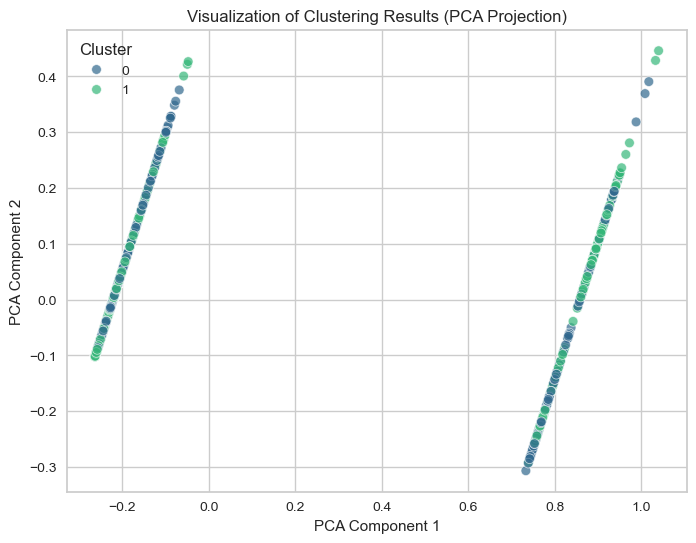

In [52]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data[['charges', 'smoker']])
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PCA1'], y=pca_df['PCA2'], hue=pca_df['Cluster'], palette='viridis', alpha=0.7)
plt.title("Visualization of Clustering Results (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [54]:
for col in categorical_features:
    data[col] = label_encoders[col].inverse_transform(data[col])
data

,age,sex,bmi,children,smoker,region,charges,Cluster
0,0.021739,female,0.321227,0.0,yes,southwest,0.251611,1
1,0.000000,male,0.479150,0.2,no,southeast,0.009636,1
2,0.217391,male,0.458434,0.6,no,southeast,0.053115,1
3,0.326087,male,0.181464,0.0,no,northwest,0.333010,0
4,0.304348,male,0.347592,0.0,no,northwest,0.043816,0
...,...,...,...,...,...,...,...,...
1332,0.695652,male,0.403820,0.6,no,northwest,0.151299,0
1333,0.000000,female,0.429379,0.0,no,northeast,0.017305,0
1334,0.000000,female,0.562012,0.0,no,southeast,0.008108,1
1335,0.065217,female,0.264730,0.0,no,southwest,0.014144,1


In [55]:
data[numerical_features] = scaler.inverse_transform(data[numerical_features])
data

,age,sex,bmi,children,smoker,region,charges,Cluster
0,19.0,female,27.900,0.0,yes,southwest,16884.92400,1
1,18.0,male,33.770,1.0,no,southeast,1725.55230,1
2,28.0,male,33.000,3.0,no,southeast,4449.46200,1
3,33.0,male,22.705,0.0,no,northwest,21984.47061,0
4,32.0,male,28.880,0.0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1332,50.0,male,30.970,3.0,no,northwest,10600.54830,0
1333,18.0,female,31.920,0.0,no,northeast,2205.98080,0
1334,18.0,female,36.850,0.0,no,southeast,1629.83350,1
1335,21.0,female,25.800,0.0,no,southwest,2007.94500,1


In [64]:
clustering_results = data.groupby('Cluster')
clustering_results.describe().T

Cluster                    0             1
age      count    648.000000    689.000000
         mean      39.263889     39.182874
         std       14.037809     14.060550
         min       18.000000     18.000000
         25%       26.750000     27.000000
         50%       39.000000     39.000000
         75%       51.000000     51.000000
         max       64.000000     64.000000
bmi      count    648.000000    689.000000
         mean      29.184498     32.054398
         std        5.550719      6.268625
         min       15.960000     17.400000
         25%       25.246250     27.600000
         50%       28.880000     31.790000
         75%       32.775000     36.190000
         max       48.070000     53.130000
children count    648.000000    689.000000
         mean       1.098765      1.092888
         std        1.185747      1.224778
         min        0.000000      0.000000
         25%        0.000000      0.000000
         50%        1.000000      1.000000
         75%        2.000000      2.000000
         max        5.000000      5.000000
charges  count    648.000000    689.000000
         mean   12928.612680  13608.772730
         std    11166.448067  12934.889050
         min     1621.340200   1121.873900
         25%     4912.897300   4646.759000
         50%     9674.460275   8978.185100
         75%    15880.760462  17626.239510
         max    60021.398970  63770.428010

In [67]:
region_results = pd.crosstab(data['Cluster'], data['region'])
smoker_results = pd.crosstab(data['Cluster'], data['smoker'])
sex_results = pd.crosstab(data['Cluster'], data['sex'])

summary = pd.concat([region_results, smoker_results, sex_results], axis=1)
summary.T

Cluster,0,1
northeast,324,0
northwest,324,0
southeast,0,364
southwest,0,325
no,523,540
yes,125,149
female,325,337
male,323,352


In [68]:
data.to_csv("../data/processed/insurance_clustered.csv", index=False)